### This is a short tutorial to get you familiar with accessing Gaia data with astroquery

In [1]:
from astroquery.gaia import Gaia
import astropy.units as u
import astropy.coordinates
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

Let's say I want to query in a rectagular region around Pleiades, and retrieve the brightest stars closer than 1000 parsecs corresponding to parallax > 1 mas). 

In SQL queries, Gaia needs RA and Dec in degrees (as far as I know), but usual places define it in hours-minutes-seconds, and degree-minutes-seconds. We can either convert it with astropy, or use string to float conversion. For astropy, look up the syntax/uses of SkyCoord. I'll use the string method here.

In [7]:
s = '05 52 17.8 +32 32 42'
c = [float(i) for i in s.split()]
ra = c[0]*15 + c[1]/4 + c[2]/240
if c[3] >= 0:
    dec = c[3] + c[4]/60 + c[5]/3600
else:
    dec = c[3] - c[4]/60 - c[5]/3600
    
print(str(format(ra - 0.6, '.2f'))+' and '+str(format(ra + 0.6, '.2f')))
print(str(format(dec - 0.6, '.2f'))+' and '+str(format(dec + 0.6, '.2f')))
print(ra, dec)

87.47 and 88.67
31.94 and 33.14
88.07416666666667 32.544999999999995


The four basic parts of ADQL queries were discussed yesterday - feel free to ask doubts if you didn't understand. The IS NOT NULL ensures that the column value is not empty for that particular source.  
We use these values and define our query inside a string, then pass that string into the Gaia interface as illustrated below:

In [3]:
query = '''
SELECT top 10000
ra, dec, parallax, phot_g_mean_mag, pm
FROM gaiadr3.gaia_source
WHERE ra > 56 AND ra < 57.2
AND dec > 23.51 AND dec < 24.71
AND parallax IS NOT NULL
AND parallax > 1
ORDER BY phot_g_mean_mag
'''

job = Gaia.launch_job_async(query)
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


Let's try to find the distance to the cluster. Cluster stars will form an overdensity at a particular distance

In [4]:
r['parallax']

8.345685150896063
7.671309961502887
7.067028703633884
9.544445082693732
7.385246890845397
7.3052753639807255
7.199902345703015
7.423127367767808
7.271150194177561
7.230057778664303
15.064495732715876


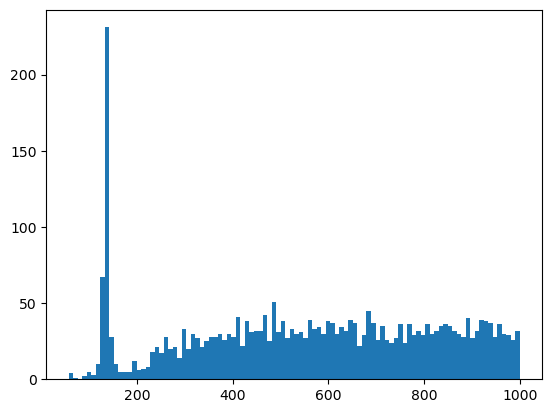

In [5]:
plt.hist(1000/r['parallax'], bins  = 100)
plt.show()

There's a clear overdensity somewhere around 150 parsecs. Let's filter only those stars using a mask

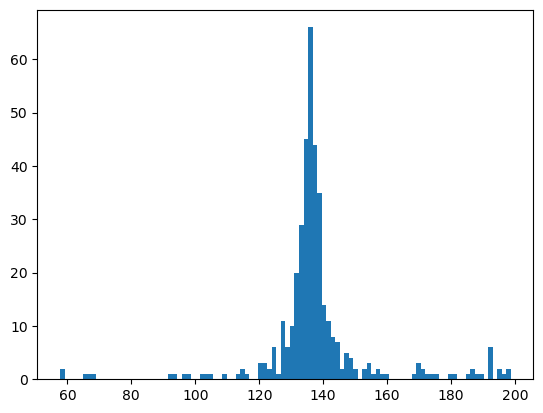

In [6]:
mask = r['parallax'] > 5  #so distance < 200 parsecs
r0 = r[mask]

plt.hist(1000/r0['parallax'], bins = 100)
plt.show()

I'll stop here, but you can look up np.histogram() to find out ways to get the exact distance from above. 

Study and implement quality cuts (error bounds etc.) from the other tutorial, then try out the following:

1. Query for the brightest stars, and study their distribution in galactic coordinates (look up matplotlib pyplot methods to do it!)
2. Query for the closest stars
3. Query for more open and globular clusters, study their distribution of pmra and pmdec (proper motions in RA and Dec)
4. Query around the galactic centre, and look for possible clumps in pmra-pmdec space.
5. Look up the other tables in Gaia datamodel, and list some ways to use that data with our usual astrometric data.

Remember to toy around with different quality cuts. DO NOT hesitate to experiment with different properties, and most importantly, have fun! Ping us on Slack in case of any doubts.

1. Query for the brightest stars, and study their distribution in galactic coordinates (look up matplotlib pyplot methods to do it!)

In [7]:
job1 = Gaia.launch_job_async('SELECT top 100000 ra, dec, parallax, phot_g_mean_mag, pm FROM gaiadr3.gaia_source WHERE parallax IS NOT NULL AND parallax > 1 ORDER BY phot_g_mean_mag')
r1 = job1.get_results()
r1['rarad'] = r1['ra']*np.pi/180
r1['decrad'] = r1['dec']*np.pi/180

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
coord1 = astropy.coordinates.TETE(ra=r1['rarad']*u.rad, dec=r1['decrad']*u.rad)
coord1 = coord1.transform_to(astropy.coordinates.Galactic())
r1['l'] = coord1.l.wrap_at(180*u.deg)
r1['b'] = coord1.b.wrap_at(180*u.deg)

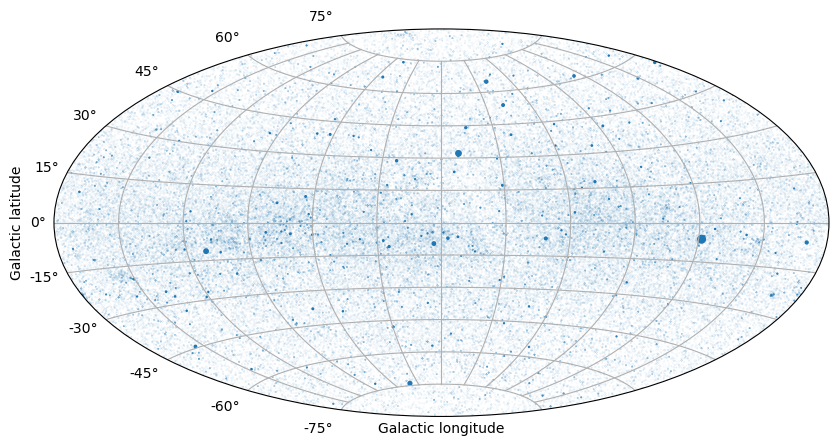

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(r1['l']*np.pi/180, r1['b']*np.pi/180, s=[30/(i+1) for i in range(len(r1['ra']))])
#plt.title("Plot of top 10000 brightest stars in galactic coordinates")
plt.xlabel("Galactic longitude")
plt.ylabel("Galactic latitude")
plt.xticks(np.array([-2.61799388, -2.0943951 , -1.57079633, -1.04719755, -0.52359878, 0., 0.52359878, 1.04719755, 1.57079633, 2.0943951, 2.61799388]), "")
plt.show()

2. Query for the closest stars

In [10]:
job2 = Gaia.launch_job_async('SELECT top 1000 ra, dec, parallax, phot_g_mean_mag, pm FROM gaiadr3.gaia_source ORDER BY parallax')
r2 = job2.get_results()
r2['rarad'] = r2['ra']*np.pi/180
r2['decrad'] = r2['dec']*np.pi/180

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
coord2 = astropy.coordinates.TETE(ra=r2['rarad']*u.rad, dec=r2['decrad']*u.rad)
coord2 = coord2.transform_to(astropy.coordinates.Galactic())
r2['l'] = coord2.l.wrap_at(180*u.deg)
r2['b'] = coord2.b.wrap_at(180*u.deg)

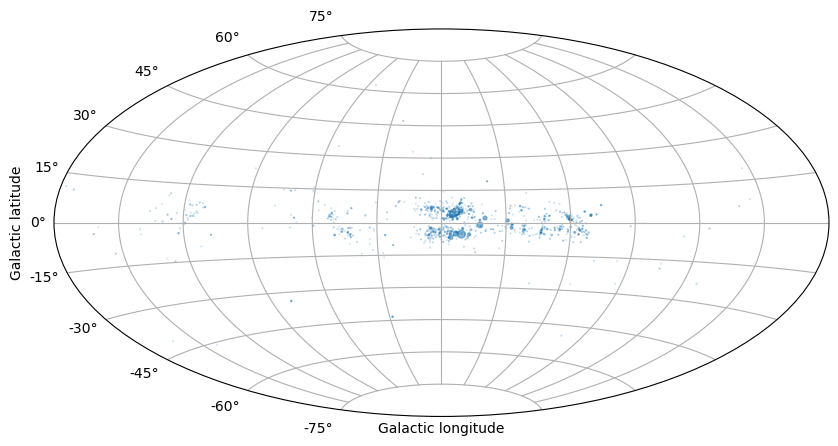

In [12]:
plt.figure(figsize=(10,7))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(r2['l']*np.pi/180, r2['b']*np.pi/180, s=[30/(i+1) for i in range(len(r2['ra']))], alpha=0.5)
#plt.title("Plot of top 10000 brightest stars in galactic coordinates")
plt.xlabel("Galactic longitude")
plt.ylabel("Galactic latitude")
plt.xticks(np.array([-2.61799388, -2.0943951 , -1.57079633, -1.04719755, -0.52359878, 0., 0.52359878, 1.04719755, 1.57079633, 2.0943951, 2.61799388]), "")
plt.show()

3. Query for more open and globular clusters, study their distribution of pmra and pmdec (proper motions in RA and Dec)

I'll be searching around the globular cluster Omega Centauri and the open cluster M44

In [13]:
#omega centauri
query3 = '''
SELECT top 10000
ra, dec, parallax, phot_g_mean_mag, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE ra > 200.1 AND ra < 203.3
AND dec > -48.5 AND dec < -47
AND abs(pmra_error/pmra)<0.10
AND abs(pmdec_error/pmdec)<0.10
AND parallax IS NOT NULL
AND parallax > 0.1
AND pmra IS NOT NULL AND abs(pmra)>0
AND pmdec IS NOT NULL AND abs(pmdec)>0
AND pmra BETWEEN -40 AND 24
AND pmdec BETWEEN -25 AND 15
ORDER BY phot_g_mean_mag
'''

job3 = Gaia.launch_job_async(query3)
r3 = job3.get_results()
r3['rarad'] = r3['ra']*np.pi/180
r3['decrad'] = r3['dec']*np.pi/180

INFO: Query finished. [astroquery.utils.tap.core]


Text(0, 0.5, 'DEC')

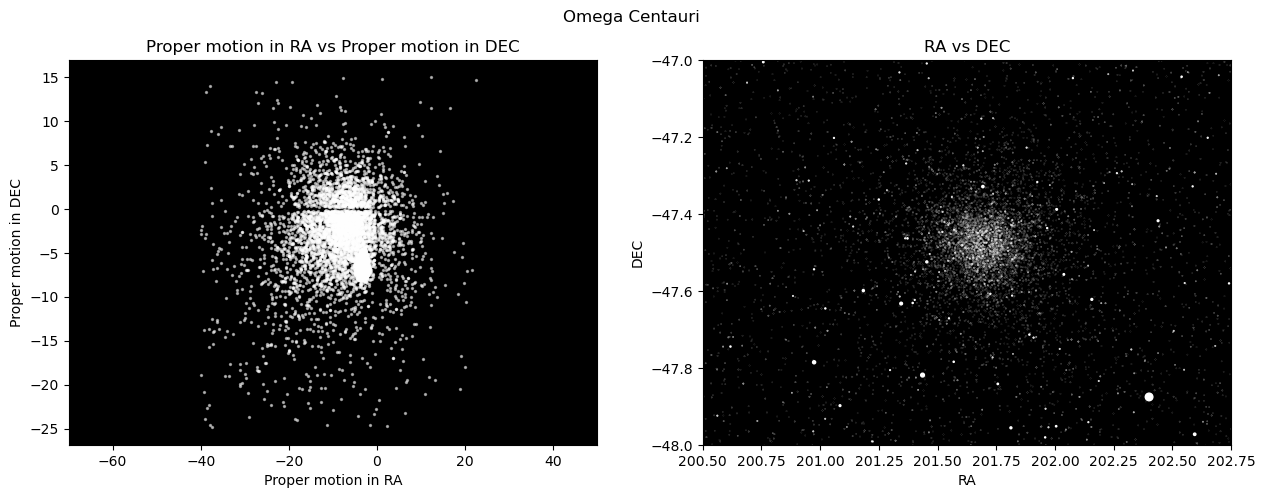

In [14]:
#omega centauri
fig, ax = plt.subplots(1,2)
plt.suptitle("Omega Centauri")
ax[0].set_facecolor('black')
ax[1].set_facecolor('black')
fig.set_figheight(5)
fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.scatter(r3['pmra'], r3['pmdec'], alpha=0.5, s=2, color='w')
plt.title("Proper motion in RA vs Proper motion in DEC")
plt.xlim(-70,50)
plt.xlabel("Proper motion in RA")
plt.ylabel("Proper motion in DEC")
plt.subplot(1,2,2)
plt.scatter(r3['ra'], r3['dec'], s=[30/(i+1) for i in range(len(r3['ra']))], color='w')
plt.title("RA vs DEC")
plt.xlim(200.5, 202.75)
plt.ylim(-48, -47)
plt.xlabel("RA")
plt.ylabel("DEC")

In [15]:
query4 = '''
SELECT top 10000
ra, dec, parallax, phot_g_mean_mag, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE ra > 129 AND ra < 131
AND dec > 19 AND dec < 21
AND abs(pmra_error/pmra)<0.10 
AND abs(pmdec_error/pmdec)<0.10
AND parallax IS NOT NULL
AND parallax > 0.1
AND pmra IS NOT NULL AND abs(pmra)>0 
AND pmdec IS NOT NULL AND abs(pmdec)>0 
AND pmra BETWEEN -50 AND 40
AND pmdec BETWEEN -50 AND 33
ORDER BY phot_g_mean_mag
'''

job4 = Gaia.launch_job_async(query4)
r4 = job4.get_results()
r4['rarad'] = r4['ra']*np.pi/180
r4['decrad'] = r4['dec']*np.pi/180

INFO: Query finished. [astroquery.utils.tap.core]


Text(0, 0.5, 'DEC')

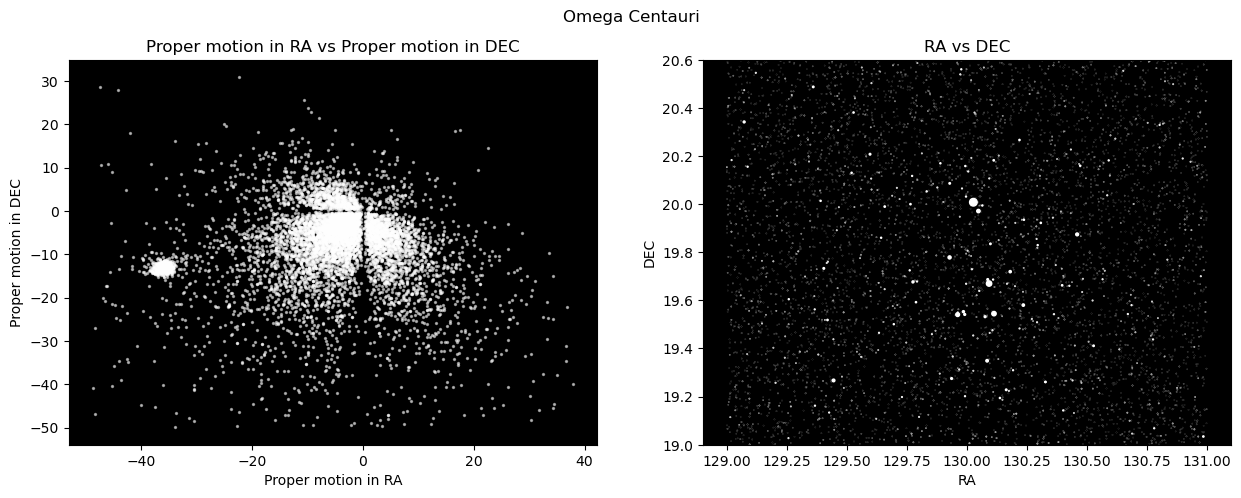

In [16]:
fig, ax = plt.subplots(1,2)
plt.suptitle("Omega Centauri")
ax[0].set_facecolor('black')
ax[1].set_facecolor('black')
fig.set_figheight(5)
fig.set_figwidth(15)
plt.subplot(1,2,1)
plt.scatter(r4['pmra'], r4['pmdec'], alpha=0.5, s=2, color='w')
plt.title("Proper motion in RA vs Proper motion in DEC")
plt.xlabel("Proper motion in RA")
plt.ylabel("Proper motion in DEC")
plt.subplot(1,2,2)
plt.scatter(r4['ra'], r4['dec'], s=[30/(i+1) for i in range(len(r4['ra']))], color='w')
plt.title("RA vs DEC")
plt.ylim(19, 20.6)
plt.xlabel("RA")
plt.ylabel("DEC")